In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
articles = 'articles.xlsx'
customers = 'customers.xlsx'
transaction_val = 'transactions_val.xlsx'
users_test = 'users_test.xlsx'
transactions_train = 'transactions_train.csv'

In [5]:
df_articles = pd.read_excel(articles)
df_customers = pd.read_excel(customers)
df_transaction_val = pd.read_excel(transaction_val)
df_users_test = pd.read_excel(users_test)
df_transaction_train = pd.read_csv(transactions_train)

In [6]:
df_articles.head()

,Unnamed: 0,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,department_no,department_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,1339,Clean Lingerie,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,1339,Clean Lingerie,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [7]:
df_customers.head()

,Unnamed: 0,customer_id,club_member_status,age,postal_code
0,0,000226b9ea81019249060b376b516f821a80e9b24f89a7...,ACTIVE,25.0,7bc2c8dd1064b51b2c0d41bdf6a5d8224bd1b16fbeaf6d...
1,1,000303d20b953d06dcf8c6db2d05616383a88ac84bf054...,ACTIVE,34.0,3e352138284f73c8b2e19d5aa0d090ec976824c28b0215...
2,2,0003e7b27d3dd2295e609bcc017e96a05f322cd25fdaa7...,ACTIVE,25.0,f2e545e054068651874a02572e39d598114043841ca920...
3,3,000416152a81973bebab23142bd5dd6ebd85c8c5e2d63e...,ACTIVE,49.0,d0b364f5ee70c84bcfd675527d143eed03573bd308bf72...
4,4,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,ACTIVE,29.0,72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...


In [8]:
df_transaction_val.head()

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id
0,0,2020-09-20,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,535035001,0.118627,2
1,1,2020-06-15,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...,654046004,0.022017,2
2,2,2019-10-20,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...,742086008,0.033881,2
3,3,2020-07-14,3219f007e898957cbe0ff0f22010cd7118c06f7498a167...,778534006,0.042356,1
4,4,2020-09-07,4e5c03f7ffefe2f99f8e0c9d9805c1571867e6a8dd7091...,706016015,0.033881,1


In [64]:
df_transaction_train

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id
0,0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2
...,...,...,...,...,...,...
1318496,1318496,2019-09-10,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,751478002,0.042356,2
1318497,1318497,2019-09-20,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,750444005,0.059305,1
1318498,1318498,2019-09-20,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,811198001,0.033881,1
1318499,1318499,2019-09-20,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,787880005,0.050831,1


In [90]:
df_transaction_train['customer_id'].value_counts()

a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1346
84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb050070369176905712     950
e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c72774e3f3338cbbb3335e     910
2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8b56e5b66c86182bedf     875
9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23704f1f654784bcda58     789
                                                                    ... 
66fa162fc899aae6601f8f049c9af7aa0e10c26024dda0fb60b15c3842594f99       2
b38789f9d20b0687e95126abc7d28cf41ef338cb6ae2965982280e15f72c0183       2
3d1fe298214ea34229b214cee278371c285d9f9bab983c2f32dfa4f45b6714bd       2
82cde6873637d99833b355158f28337a272034c426ad792bf4544eea59ac505b       2
634754c3b9f1fd3479985776813c1f9d14486ad596459c34f20ed259d23c9cbd       2
Name: customer_id, Length: 45000, dtype: int64

# Actividad 1

Grafique la distribucion del numero de compras por usuario, identifique los ids de los 
10 usuarios mas activos en el dataset. Comente la forma de la distribucion obtenida y
que porcentaje de las interacciones han sido hechas por estos 10 usuarios.

10 usuarios mas activos:

In [101]:
agrupado_compras_por_usuario = df_transaction_train.groupby(['customer_id']).size().reset_index(name='compras_por_usuario')
agrupado_compras_por_usuario = agrupado_compras_por_usuario.sort_values(by='compras_por_usuario', ascending=False)
agrupado_compras_por_usuario.head(10)

,customer_id,compras_por_usuario
29300,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,1346
23387,84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb...,950
40316,e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c727...,910
8155,2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8...,875
28011,9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23...,789
33036,bbebb44478948f5052c3f4c5dc04f08653e7938886a856...,740
37241,d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9...,724
30502,ad3090d52d11671ffb43bfaa85e3620eff669e8c92c911...,670
244,0152d53f51444891ea07013fd1fb8325415bb09bb6798a...,664
315,01a4717d38b651e46dda7f1ab8d1494af2682a847fa9a5...,651


In [104]:
cantidad_usuario_por_compras = agrupado_compras_por_usuario.groupby(['compras_por_usuario']).size().reset_index(name='cantidad_usuario_por_compras')
cantidad_usuario_por_compras['percentage'] = cantidad_usuario_por_compras['cantidad_usuario_por_compras'] / cantidad_usuario_por_compras['cantidad_usuario_por_compras'].sum() * 100
cantidad_usuario_por_compras

,compras_por_usuario,cantidad_usuario_por_compras,percentage
0,2,2851,6.335556
1,3,2767,6.148889
2,4,2814,6.253333
3,5,3052,6.782222
4,6,2860,6.355556
...,...,...,...
400,789,1,0.002222
401,875,1,0.002222
402,910,1,0.002222
403,950,1,0.002222


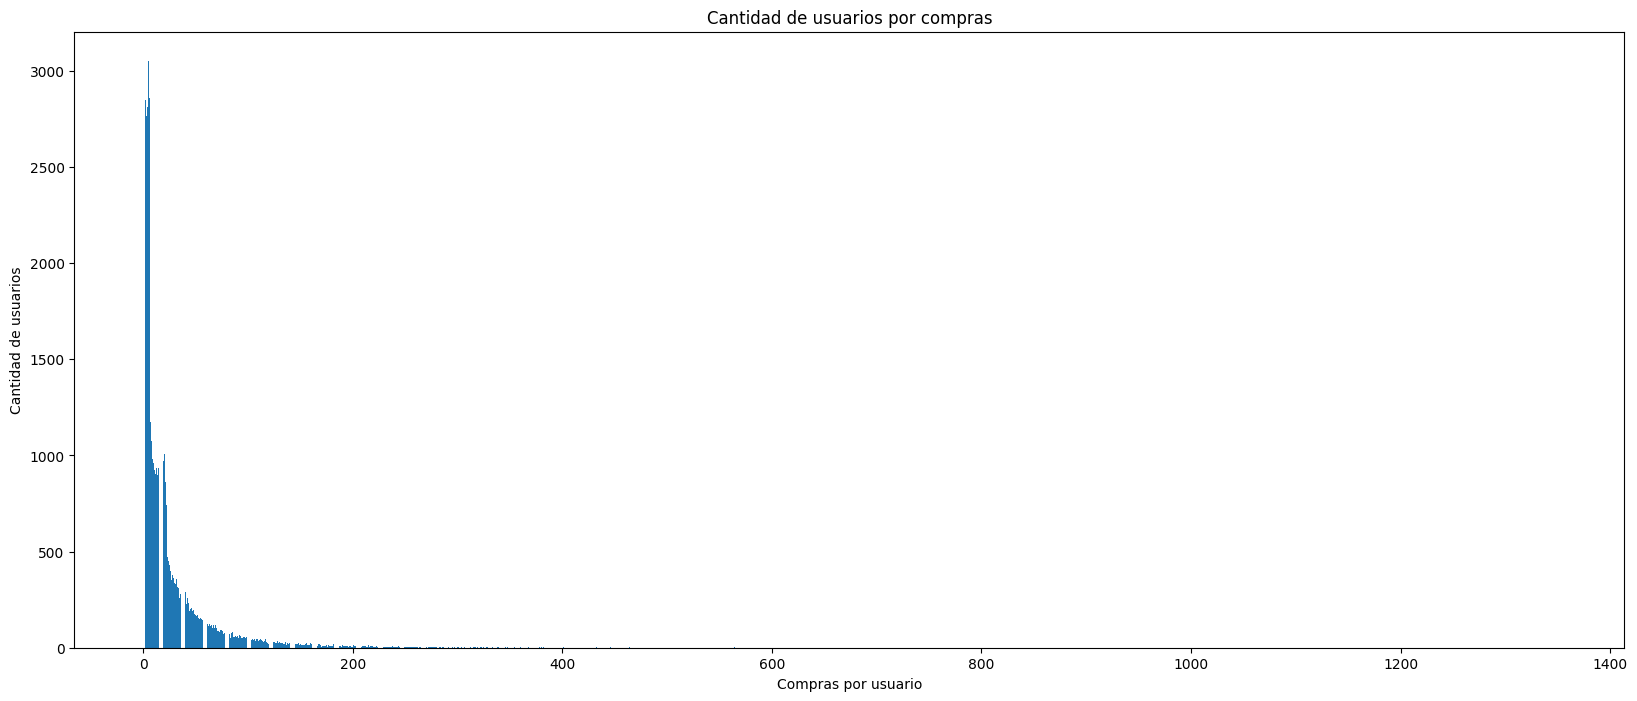

In [112]:
# graficar eje x copmrar por usuario eje y cantidad de usuarios, y poner sobre la barra el porcentaje
plt.figure(figsize=(20, 8))
plt.bar(cantidad_usuario_por_compras['compras_por_usuario'], cantidad_usuario_por_compras['cantidad_usuario_por_compras'])
plt.xlabel('Compras por usuario')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de usuarios por compras')
plt.show()

In [95]:
agrupado_prod = df_transaction_train.groupby(['article_id']).size().reset_index(name='count')
agrupado_prod

,article_id,count
0,108775015,550
1,108775044,359
2,108775051,10
3,110065001,48
4,110065002,26
...,...,...
73075,946748004,11
73076,946764003,4
73077,946827001,3
73078,947509001,3


In [96]:
agrupado_prod = agrupado_prod.sort_values(by='count', ascending=False)
agrupado_prod.head(10)

,article_id,count
36789,706016001,1978
36790,706016002,1357
14906,610776002,1302
1174,372860001,1225
49637,759871002,1010
1548,399223001,991
2540,464297007,920
8501,562245001,899
8514,562245046,849
1175,372860002,849


In [97]:
df_users_test.head()

,Unnamed: 0,customer_id
0,0,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...
1,1,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...
2,2,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...
3,3,3219f007e898957cbe0ff0f22010cd7118c06f7498a167...
4,4,4e5c03f7ffefe2f99f8e0c9d9805c1571867e6a8dd7091...


In [98]:
df_transaction_train.head()

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id
0,0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2


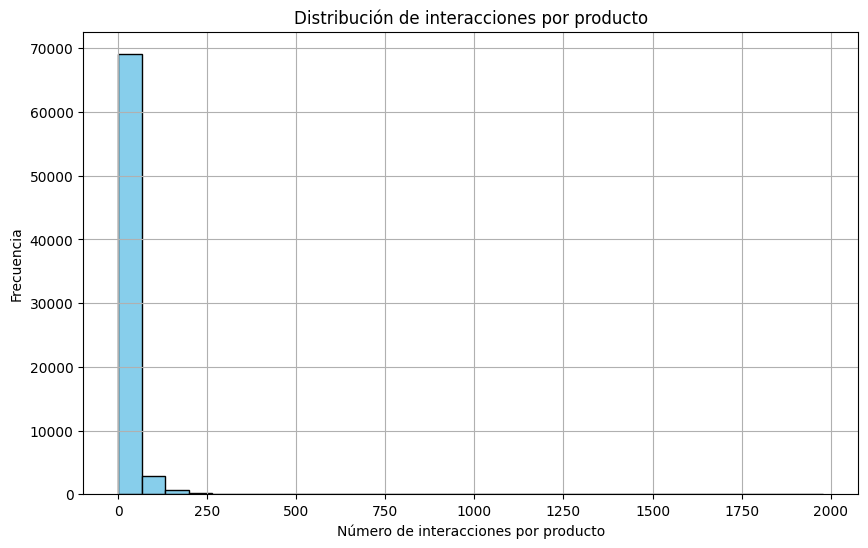

In [99]:
# Graficar la distribución de interacciones por producto
plt.figure(figsize=(10, 6))
plt.hist(agrupado_prod['count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Número de interacciones por producto')
plt.ylabel('Frecuencia')
plt.title('Distribución de interacciones por producto')
plt.grid(True)
plt.show()